In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import rowan
import numpy as np
from scipy.spatial.transform import Rotation as R


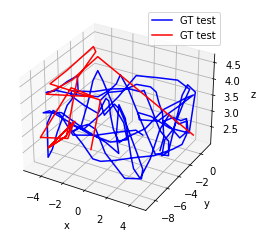

In [2]:
train_data = pd.read_csv(f'D:/Imperial/FYP/captured_data/airsim_drone_mode/test/airsim_rec_0.txt', sep="\t")
train_data_1 = pd.read_csv(f'D:/Imperial/FYP/captured_data/airsim_drone_mode/test/airsim_rec_1.txt', sep="\t")

plt.figure()
ax = plt.axes(projection= '3d')
ax.plot3D(train_data["POS_X"], train_data["POS_Y"], -train_data["POS_Z"], label = "GT test", color = 'blue')
ax.plot3D(train_data_1["POS_X"], train_data_1["POS_Y"], -train_data_1["POS_Z"], label = "GT test", color = 'red')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.legend()
plt.show()

In [28]:
train_data["timestamp"] = pd.to_datetime(train_data["timestamp"], unit='ns')
train_data["seconds"] = (train_data["timestamp"] - train_data["timestamp"][0]).dt.total_seconds()
train_data["incremental_seconds"] = (train_data["seconds"] - train_data["seconds"].shift(1))

In [29]:
train_data["prev_Q_W"] = train_data["Q_W"].shift(1)
train_data["prev_Q_X"] = train_data["Q_X"].shift(1)
train_data["prev_Q_Y"] = train_data["Q_Y"].shift(1)
train_data["prev_Q_Z"] = train_data["Q_Z"].shift(1)

## Acceleration

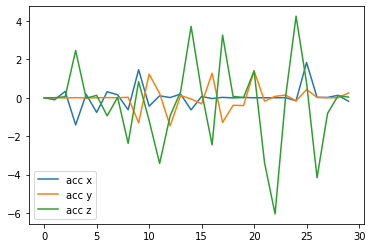

In [30]:
plt.figure()
train_data["LIN_ACC_X"].plot()
train_data["LIN_ACC_Y"].plot()
train_data["LIN_ACC_Z"].plot()
plt.legend(["acc x", "acc y", "acc z"])
plt.show()

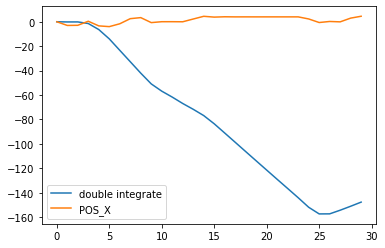

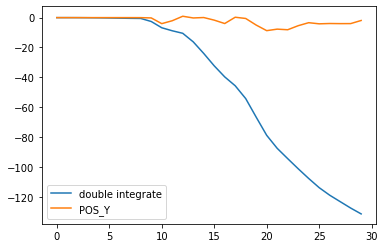

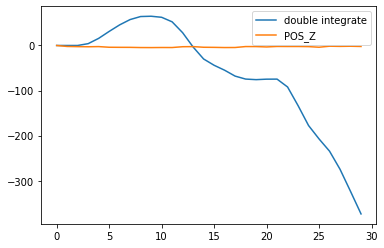

In [31]:
from scipy import integrate
t = train_data["seconds"]
velocity = integrate.cumtrapz(train_data["LIN_ACC_X"], t, initial=0)
displacement = integrate.cumtrapz(velocity, t, initial=0)

plt.plot(displacement, label = "double integrate")
plt.plot(train_data["POS_X"], label = "POS_X")
plt.legend()

plt.figure()
velocity = integrate.cumtrapz(train_data["LIN_ACC_Y"], t, initial=0)
displacement = integrate.cumtrapz(velocity, t, initial=0)

plt.plot(displacement, label = "double integrate")
plt.plot(train_data["POS_Y"], label = "POS_Y")
plt.legend()

plt.figure()
velocity = integrate.cumtrapz(train_data["LIN_ACC_Z"], t, initial=0)
displacement = integrate.cumtrapz(velocity, t, initial=0)

plt.plot(displacement, label = "double integrate")
plt.plot(train_data["POS_Z"], label = "POS_Z")
plt.legend()

## Angular Velocity

In [7]:
train_data.fillna(0, inplace =True)
train_data.head()

,Vehicle_name,timestamp,POS_X,POS_Y,POS_Z,Q_W,Q_X,Q_Y,Q_Z,LIN_ACC_X,...,S_ANG_VEL_X,S_ANG_VEL_Y,S_ANG_VEL_Z,ImageFile,seconds,incremental_seconds,prev_Q_W,prev_Q_X,prev_Q_Y,prev_Q_Z
0,,2022-05-10 22:13:32.495484928,0.000000,0.000000,0.247078,1.000000,-0.000000,0.000000,0.000000,-0.048520,...,0.000739,0.747320,0.053060,0.png,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,,2022-05-10 22:13:32.742969088,-0.025502,-0.000092,0.048192,0.995978,0.003354,0.075829,0.047601,-1.537490,...,0.012661,0.176386,0.665962,1.png,0.247484,0.247484,1.000000,-0.000000,0.000000,0.000000
2,,2022-05-10 22:13:32.987453440,-0.124054,-0.000433,-0.148339,0.989683,0.009631,0.083175,0.116259,-1.233152,...,-0.014629,-0.061681,0.389144,2.png,0.491969,0.244484,0.995978,0.003354,0.075829,0.047601
3,,2022-05-10 22:13:33.224438272,-0.269621,-0.000829,-0.196637,0.987288,0.010259,0.071805,0.141427,-1.296616,...,-0.042204,-0.147098,-0.048947,3.png,0.728953,0.236985,0.989683,0.009631,0.083175,0.116259
4,,2022-05-10 22:13:33.468922624,-0.542062,-0.001299,-0.299805,0.990632,0.006333,0.048746,0.127405,-0.923126,...,-0.038280,-0.143036,-0.179225,4.png,0.973438,0.244484,0.987288,0.010259,0.071805,0.141427


In [8]:
def integrate_angular_velocity(row):
	return rowan.calculus.integrate(np.hstack([row["prev_Q_W"], row["prev_Q_X"], row["prev_Q_Y"], row["prev_Q_Z"]]), 
							 np.hstack([row["ANG_VEL_X"],row["ANG_VEL_Y"], row["ANG_VEL_Z"]]), row["incremental_seconds"])

train_data["pred_Q_W"] = train_data.iloc[1:,:].apply(lambda row: integrate_angular_velocity(row)[0], axis=1)
train_data["pred_Q_X"] = train_data.iloc[1:,:].apply(lambda row: integrate_angular_velocity(row)[1], axis=1)
train_data["pred_Q_Y"] = train_data.iloc[1:,:].apply(lambda row: integrate_angular_velocity(row)[2], axis=1)
train_data["pred_Q_Z"] = train_data.iloc[1:,:].apply(lambda row: integrate_angular_velocity(row)[3], axis=1)

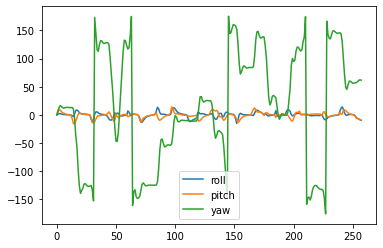

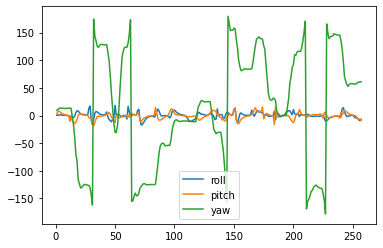

In [9]:
def convert_quat_to_euler(row, pred=False):
	if pred:
		r = R.from_quat(np.hstack([row["pred_Q_X"], row["pred_Q_Y"], row["pred_Q_Z"], row["pred_Q_W"]]))
	else:
		r = R.from_quat(np.hstack([row["Q_X"], row["Q_Y"], row["Q_Z"], row["Q_W"]]))
	return r.as_euler('xyz', degrees = True) #extrinsic rotation (Fixed frame)

train_data["roll"] = train_data.apply(lambda row: convert_quat_to_euler(row)[0], axis=1)
train_data["pitch"] =train_data.apply(lambda row: convert_quat_to_euler(row)[1], axis=1) 
train_data["yaw"] = train_data.apply(lambda row: convert_quat_to_euler(row)[2], axis=1)
train_data["pred_roll"] = train_data.iloc[1:,:].apply(lambda row: convert_quat_to_euler(row, True)[0], axis=1)
train_data["pred_pitch"] =train_data.iloc[1:,:].apply(lambda row: convert_quat_to_euler(row, True)[1], axis=1) 
train_data["pred_yaw"] = train_data.iloc[1:,:].apply(lambda row: convert_quat_to_euler(row, True)[2], axis=1)

plt.figure()
train_data["roll"].plot()
train_data["pitch"].plot()
train_data["yaw"].plot()
plt.legend(["roll", "pitch", "yaw"])

plt.figure()
train_data["pred_roll"].plot()
train_data["pred_pitch"].plot()
train_data["pred_yaw"].plot()
plt.legend(["roll", "pitch", "yaw"])

## Handling IMU

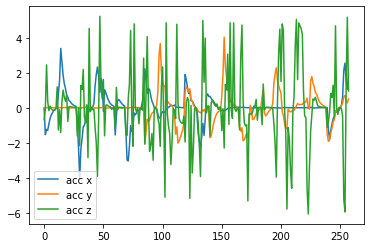

In [10]:
plt.figure()
train_data["LIN_ACC_X"].plot()
train_data["LIN_ACC_Y"].plot()
train_data["LIN_ACC_Z"].plot()
plt.legend(["acc x", "acc y", "acc z"])
plt.show()

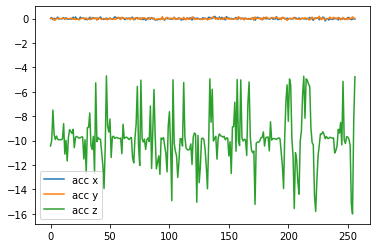

In [11]:
plt.figure()
train_data.iloc[:-1,:]["S_LIN_ACC_X"].astype(float).plot()
train_data.iloc[:-1,:]["S_LIN_ACC_Y"].astype(float).plot()
train_data.iloc[:-1,:]["S_LIN_ACC_Z"].astype(float).plot()
plt.legend(["acc x", "acc y", "acc z"])
plt.show()

In [12]:
def convert_body_to_world(row):
	body_acc = np.hstack([row["S_LIN_ACC_X"], row["S_LIN_ACC_Y"], row["S_LIN_ACC_Z"]]).astype(float)
	r = R.from_quat(np.hstack([row["Q_X"], row["Q_Y"], row["Q_Z"], row["Q_W"]]))
	world_acc = r.apply(body_acc)
	return world_acc - np.array([0, 0, -9.81])
train_data["S_LIN_ACC_X_world"] = train_data.iloc[:-1,:].apply(lambda row : convert_body_to_world(row)[0], axis = 1)
train_data["S_LIN_ACC_Y_world"] = train_data.iloc[:-1,:].apply(lambda row : convert_body_to_world(row)[1], axis = 1)
train_data["S_LIN_ACC_Z_world"] = train_data.iloc[:-1,:].apply(lambda row : convert_body_to_world(row)[2], axis = 1)

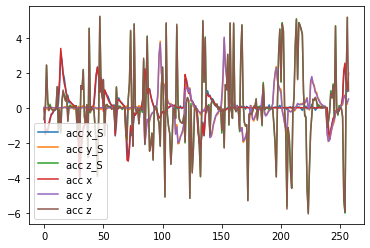

In [13]:
plt.figure()
train_data.iloc[:-1,:]["S_LIN_ACC_X_world"].astype(float).plot()
train_data.iloc[:-1,:]["S_LIN_ACC_Y_world"].astype(float).plot()
train_data.iloc[:-1,:]["S_LIN_ACC_Z_world"].astype(float).plot()
train_data["LIN_ACC_X"].plot()
train_data["LIN_ACC_Y"].plot()
train_data["LIN_ACC_Z"].plot()
plt.legend(["acc x_S", "acc y_S", "acc z_S", "acc x", "acc y", "acc z"])
plt.show()